In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import dask
import cartoframes
from cartoframes import CartoContext, Credentials

import math as m


#### Let's start with the raw data

In [160]:
central='M010'
df= pd.read_hdf('data_parks_M010.hdf'.format(central),key='/{}'.format(central)).reset_index(drop=True)

In [17]:
print("Data is {} dimensions".format(df.shape))

Data is (4041851, 8) dimensions


#### Export the raw data into CARTO
Using cartoframes, we can export the raw data in order to make some quick maps of our data. 

Set up the credentials first.

In [4]:
creds = Credentials(key='8b831d5ece6d5a6d5d567a4a23449406f726e435', 
                    username='parksgps')
base_url = 'https://parksgps.carto.com'
creds.save()
# cxn = CartoContext()

In [127]:
df.to_csv('data_cleaning_tests.csv')

In [128]:
# cc = cartoframes.CartoContext(creds=creds)
# cc.write(df, 'data_cleaning_tests',
#          lnglat=('lng', 'lat'),
#          overwrite=True)

In [ ]:
df_carto = pd.read_csv('{}/api/v2/sql?q=SELECT+*+FROM+data_cleaning_tests&format=csv'.format(base_url)).set_index('cartodb_id')

# Data Cleaning
- Remove duplicate points (Check for lat, lng, and timestamp overlap):

    `df=df.drop_duplicates(subset=['lat','lng','timestamp'])`


- Filter “reasonable” values for: 
	- Accuracy - Make sure the values are >0
	- Timestamp - 
	- Lat/lng
- Providers that don’t fulfill a certain set of requirements: 
	- Don’t have at least 100 points

## Duplicated points
Let's first see what the duplicated points look like

In [161]:
df[df.duplicated(subset=['lat','lng','timestamp'],keep=False)].sort_values(['user_id','timestamp']).head(30)

,Unnamed: 0,provider,user_id,dtype,lat,lng,accuracy,timestamp
29058,275540,1003,0000465c-6cac-4d97-a50d-2952d7527e68,IDFA,40.769588,-73.973801,10.0,1.495022e+09
1465557,201231,1003,0000465c-6cac-4d97-a50d-2952d7527e68,IDFA,40.769588,-73.973801,10.0,1.495022e+09
3061402,104212,1003,0000465c-6cac-4d97-a50d-2952d7527e68,IDFA,40.769588,-73.973801,10.0,1.495022e+09
949379,142989,1003,00010b27-f353-435d-bb02-1fd80a1bd3e4,IDFA,40.792099,-73.962852,10.0,1.495142e+09
2525386,274910,1003,00010b27-f353-435d-bb02-1fd80a1bd3e4,IDFA,40.792099,-73.962852,10.0,1.495142e+09
3878624,130421,1003,00010b27-f353-435d-bb02-1fd80a1bd3e4,IDFA,40.792099,-73.962852,10.0,1.495142e+09
469154,48869,1003,00010b27-f353-435d-bb02-1fd80a1bd3e4,IDFA,40.774330,-73.975563,1414.0,1.495144e+09
1906821,465269,1003,00010b27-f353-435d-bb02-1fd80a1bd3e4,IDFA,40.774330,-73.975563,1414.0,1.495144e+09
3503639,47889,1003,00010b27-f353-435d-bb02-1fd80a1bd3e4,IDFA,40.774330,-73.975563,1414.0,1.495144e+09
1319874,198588,1003,00010b27-f353-435d-bb02-1fd80a1bd3e4,IDFA,40.774090,-73.973244,1414.0,1.495749e+09


Now drop the duplicates based on lat,lng,timestamp.

In [162]:
df=df.drop_duplicates(subset=['lat','lng','timestamp'])

We can see that there are a lot of duplicated points

In [163]:
print("Data is now {} dimensions".format(df.shape))

Data is now (931067, 8) dimensions


## Reasonable values

### Accuracy
Find points in which the accuracies do not make sense, i.e. `accuracy < 0` and then remove those users entirely.  

We can see that there are not a ton of users so we don't lose that much data. 

In [164]:
df[df.accuracy<0]['user_id'].unique()

array(['9e9bcc3a-aeb8-4ca0-93f8-d91c6d5c840e',
       'a3881367-ed30-4f44-9b08-b343d8cf2693',
       '530be1c1-accd-4425-aea6-8a5502655c3e',
       '3153ba85-2572-4d3f-b0f5-fec3874ebbe6'], dtype=object)

In [165]:
df = df[df.accuracy>=0]

### Timestamp

Turn the timestamp into pandas datetime objects. And filter out for any potential timestamps that don't make sense and remove those users.

In [166]:
df['timestamp_new']= pd.to_datetime(df['timestamp'],unit='s')

In [167]:
date_min = '2017-05-1'
date_max = '2017-06-1'
print("Dimensions of bad dates less than {}".format(df[(df['timestamp_new']<date_min) |(df['timestamp_new']>date_max)].shape))

Dimensions of bad dates less than (0, 9)


### Lattitude/Longitude
Plot a quick distribution of the lat/lngs to make sure they fall roughly in the proper range

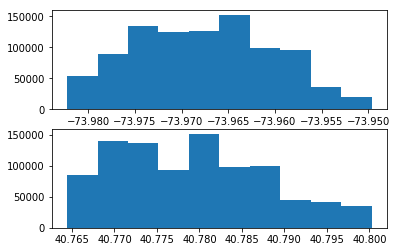

In [168]:
plt.subplot(211)
plt.hist(df.lng)

plt.subplot(212)
plt.hist(df.lat)
# 
plt.show()

### Bad providers
We create a metric that determines what's a 'bad' provider. Let's call 'bad' providers those providers for which any of the following are true: 
* The provider has fewer than 100 points in total 
* The provider has fewer than 5 users.
* The provider has an average accuracy greater than 100m

First let's get some summary stats:
- Count
- Average accuracy

In [169]:
df_summary = df.groupby('provider')\
                    .count()\
                    .sort_values('timestamp',ascending=False)[['timestamp']]
df_summary =df_summary.merge(df.groupby('provider')\
                        .mean()\
                        .sort_values('timestamp',ascending=False)[['accuracy']], \
                left_index=True, \
                right_index=True)
df_summary = df_summary.rename(columns={'timestamp': 'count'})

Let's now take a look at the general distribution of accuracies across the different providers

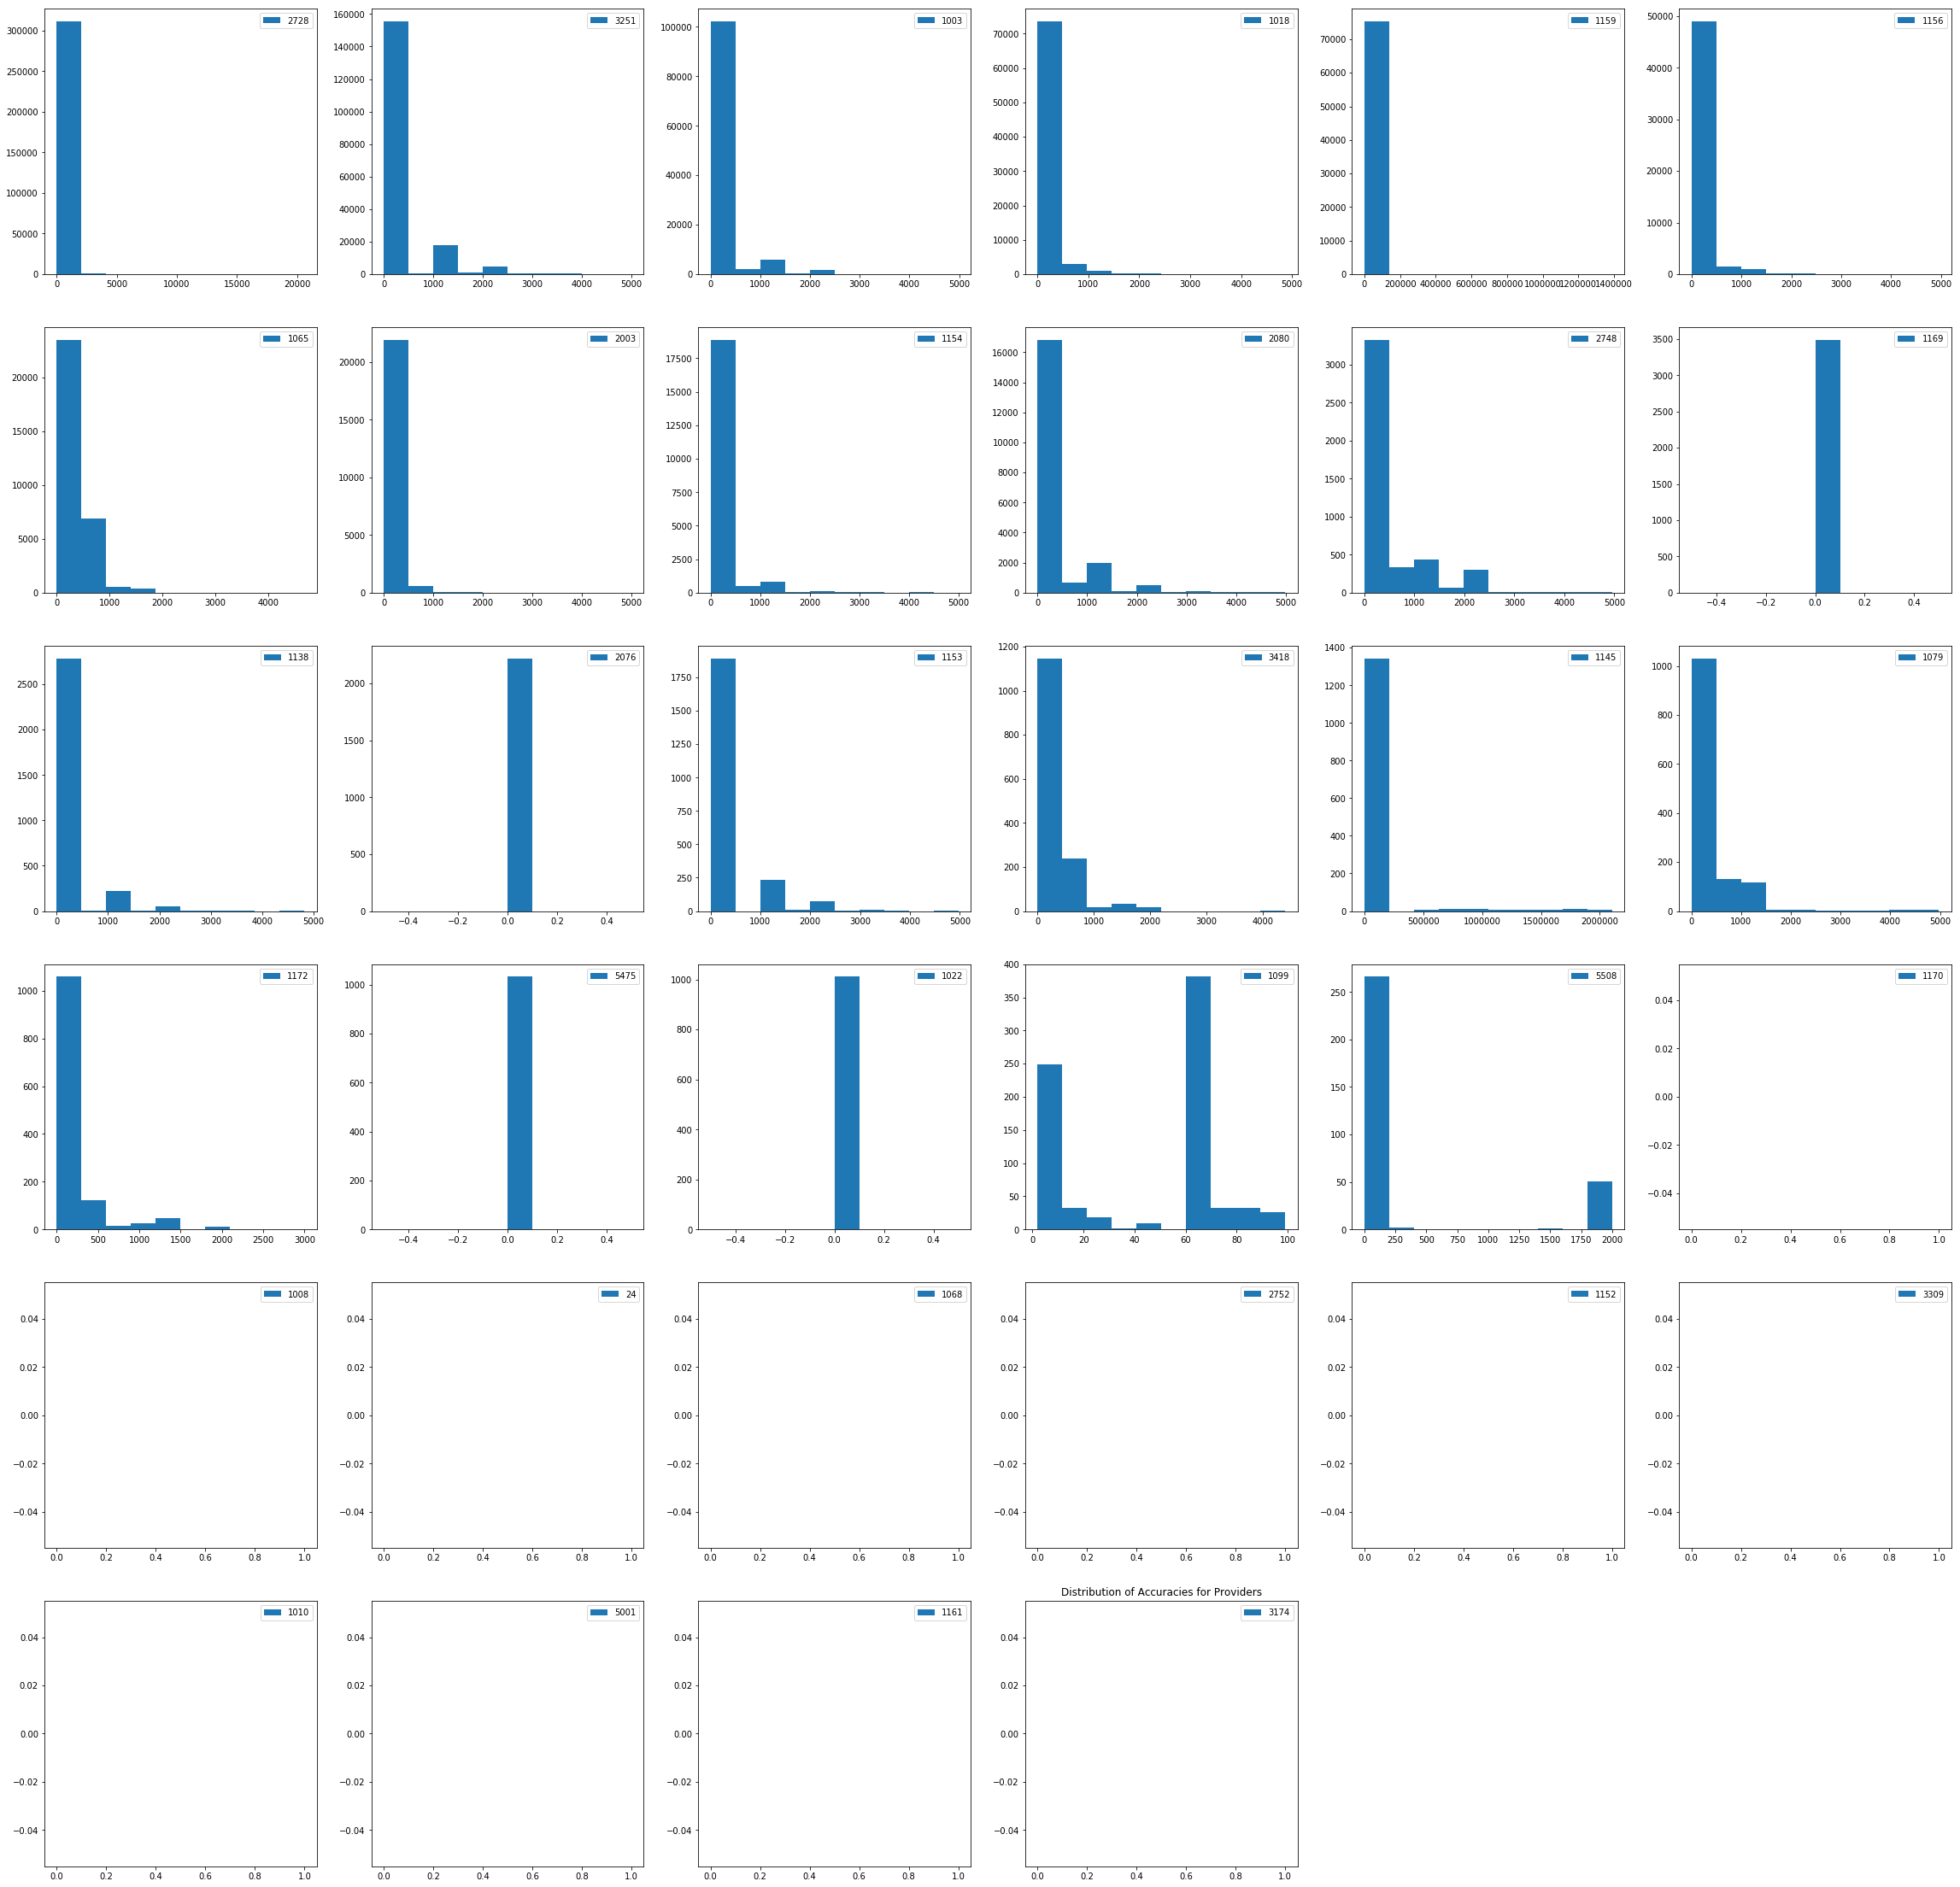

In [181]:
num_providers =df_summary.shape[0]
grid_num = m.ceil(num_providers**(.5))
plt.figure(figsize=(40,40))
# fig = plt.figure(figsize=(30,30))

for i,v in enumerate(df_summary.index):
    plt.subplot(grid_num,grid_num,i+1)
    plt.hist(df[df.provider ==v].accuracy,label="{}".format(v))
    plt.legend()

plt.title('Distribution of Accuracies for Providers')
plt.show()


#### Counts per day
Remove all those providers that have pings fewer than 10 pings a day.

In [172]:
time_range = (df['timestamp_new'].max()-df['timestamp_new'].min()).days
df = df[df.provider.isin(list(df_summary[df_summary['count']/31>10].index))]

In [184]:
print("Data is now {} dimensions".format(df.shape))

Data is now (929864, 9) dimensions


#### Accuracies
Remove all users that have more than 25% bad accuracies in their data. 


In [214]:
acc_perc = 0.25
user_acc = df.groupby('user_id').apply(lambda x: x.quantile(q=1-acc_perc).accuracy )

In [228]:
acc_thres = 100
df = df[df.user_id.isin(user_acc[user_acc<acc_thres].index)]

In [229]:
print("Data is now {} dimensions".format(df.shape))

Data is now (744261, 9) dimensions


# Creating Features
Identify the following characteristics for each point:
- Unique trip
- Velocty
- Bearing
- Travel mode




## Unique trips
For $N$ timestamps at each point $\{t_{u,1},t_{u,2},...,t_{u,N}\}$ for any user: 
\begin{equation}
trip_{u,1} = \{t_{u,1},\dots, t_{u,k}\} \quad \textrm{s.t.}\quad  |t_{u,k_i}-t_{u,k_j}|<\epsilon \\
\vdots \\
trip_{u,T} = \{t_{u,N-l},\dots, t_{u,N}\} \quad \textrm{s.t.}\quad  |t_{u,n_i}-t_{u,n_j}|<\epsilon \\
\quad \textrm{and}\quad  \\
|t_{u_k} - t_{u_n}|>\epsilon
\end{equation}


In [256]:
from joblib import Parallel, delayed
import multiprocessing
from itertools import chain

### We're parallelizing some of these functions 
def applyParallel(dfGrouped, func,col='timestamp'):
    '''
    Parallelizes groupby-apply functions
    
    dfGrouped = pandas group (from groupby function)
    func = function that's applied to each group
    col = Column in the for the operation
    '''
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group[col]) for name, group in dfGrouped)
    return retLst

def time_cluster_user(x,eps=1200): 
    '''
    For each user, clusters their paths by timestamp, anything timestamp that's more than 
    some time-delta from each other gets binned into a separate path label. 
    
    x = a series of timestamps for one user
    eps = time-delta in seconds, depending on what the format timestamp is in
    '''
    x = x.sort_values()
    x_diff = x.diff()
    x_diff_rs =  x_diff.reset_index(drop=True)
    breaks=x_diff_rs[x_diff_rs>eps].index.values
    labels =x_diff.copy()
    labels[:]=0
    counter = 1
    for each in breaks: 
        labels.iloc[each:]=counter
        counter+=1

    return dict(zip(labels.index.values,labels))


def time_cluster(df,eps=1200):
    '''
    Runs the trip labels and dataframe indices 
    '''
    trip_labels=applyParallel(df.groupby('user_id'), time_cluster_user)
    
    ### Trip labels for each user
    labels = np.array(list(chain.from_iterable([list(t.values()) for t in trip_labels])))
    ### Index for trip label
    idx_val = np.array(list(chain.from_iterable([list(t.keys()) for t in trip_labels])))
    print('Time clustering done')
    return labels, idx_val

In [282]:
#### Example for creating trip labels
labels,label_indicies = time_cluster(df,1200)
df.loc[list(label_indicies),'trip_ID']=labels
df['trip_ID']=["{}_{}".format(x,y) \
               for x,y in zip(df.user_id.values,\
                              df.trip_ID.values)]

Time clustering done


/Users/wenfeixu/anaconda2/envs/geo_wenfei/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/wenfeixu/anaconda2/envs/geo_wenfei/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Now, let's re-index the data by trip ID and by timestamp

In [288]:
df.sort_values(['trip_ID','timestamp']).reset_index(inplace=True)

## Trip length
Now that we have the trip_IDs, we can calculate the total time-delta of each trip. 

In [347]:
def trip_length(df_trip,col='timestamp'):
    '''
    Get's the trip length for one trip
    '''
    return df_trip[col].max()-df_trip[col].min()

def trip_length_ALL(df,grp ='trip_ID',time_col='timestamp'):
    trip_lengths = df.groupby(grp).apply(lambda x: trip_length(x,time_col))
    return trip_lengths

## Velocity 
We will define the velocity as: $$\frac{d(p_i,p_j)}{t_{p_i}-t_{p_j}}$$ , where distance is in meters and time is per hour.


Here, we can calculate distances using either the Great Circle or Vincenty. Great Circle is faster but less precise. From Wikipedia: 
* "Vincenty's formulae are two related iterative methods used in geodesy to calculate the distance between two points on the surface of a spheroid, developed by Thaddeus Vincenty (1975a) They are based on the assumption that the figure of the Earth is an oblate spheroid, and hence are more accurate than methods such as great-circle distance which assume a spherical Earth"

Here are some functions that will help us in this calculation

In [302]:
from geopy.distance import great_circle
from geopy.distance import vincenty

### We can calculate distances using either the Great Circle or Vincenty
def distance_vinc(x1,x2):
    return vincenty(x1,x2).meters

def distance_great_circle(x1,x2):
    '''
    where x1,x2 are in the form (lng,lnt)
    '''
    return great_circle(x1,x2).meters

In [324]:
#### SKETCH
def function_to_calc_velocity(df):
    '''
    Calculate the velocity per set of points in the trip. 
    One velocity will be assigned to each point

    Remember to skip the first row, which should get a value of 0
    '''
    velocities = df.apply(lambda x: distance_great_circle((x['lng'],x['lat']),\
                                       (x.shift(-1)['lng'],x.shift(-1)['lat']))/\
                          (x.shift(-1)['timestamp']-x.shift['timestamp']),axis=1)

    return velocities


## Bearing

In [337]:
#### SKETCH: I got this from stackoverflow answer somewhere, but never revised
def comp_bearing(self,pointA, pointB):
    """
    Calculates the bearing between two points.
    The formulae used is the following:
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    :Parameters:
      - `pointA: The tuple representing the latitude/longitude for the
        first point. Latitude and longitude must be in decimal degrees
      - `pointB: The tuple representing the latitude/longitude for the
        second point. Latitude and longitude must be in decimal degrees
    :Returns:
      The bearing in degrees
    :Returns Type:
      float
    """
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])

    diffLong = math.radians(pointB[1] - pointA[1])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing


### Trip mode
Using the velocity that's been calculated, we can then calculate a trip mode. 

In [338]:
def trip_mode(df):

    '''
    if (velocity<.05) :
        df.loc[i,'travel_mode']='stay'
    elif (velocity <3.1) and (velocity >=.05):
        df.loc[i,'travel_mode']='walking'
    elif (velocity <10) and (velocity >=3.1):
        df.loc[i,'travel_mode']='running'
    else:
        df.loc[i,'travel_mode']='other' 
    '''
    return df


## HDBSCAN
Read the docs for how HDBSCAN works here: http://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

The spatial clustering itself is quite straightfoward; however, we need to find the appropriate `min_pts` to calculate. One method is find the density of points in the area we are looking at, and then to callibrate the min points based on that. 


This is an example of how the `min_pts` was calculated for the parks project. For $M_p$= minimum number of points in the cluster, $N_p$ = total number of points in the dataframe, $a_p$ area of the region in consideration. The range of all possible points is $[10,100]$. 
$$M_p = min(max(\frac{100*N_p}{a_p},10),100)$$

In [340]:
### Find the park area
park_area = park_geoms.groupby('signname').sum()['area_m'].loc[park]

### The min_pts in the cluster
def get_min_pts(df,area):
    min_pts=min(max(int(len(df)/area*100),10),100)
    return min_pts

Once we have $M_p$, the minimum number of points in the cluster, we can use the HDBSCAN algorithm. 

In [ ]:

def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

def hdbscan_spatial(coords,min_pts):
    '''
    Create the clusters using **HDBSCAN**.
    coords = df[['lng','lat']].values
    '''
    
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_pts)

    cluster_labels = clusterer.fit_predict(coords)
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([coords[cluster_labels== n] for n in range(num_clusters)])
    
    ### Optional: return the center
    centermost_points = clusters[:-1].map(get_centermost_point)

    return(cluster_labels,num_clusters,clusters)


## Dwelltime
For each cluster, or any set of points where we know that there is a subset of a trip in this set, we can calculate a dwellltime. So, for

\begin{equation}
trip_{u,1} =\{t_{u,1},\dots, t_{u,k}\} \\
\vdots \\
trip_{u,T} = \{t_{u,N-l},\dots, t_{u,N}\} \quad \textrm{s.t.}\quad  |t_{u,n_i}-t_{u,n_j}|<\epsilon \\
\quad \textrm{and}\quad  \\
|t_{u_k} - t_{u_n}|>\epsilon
\end{equation}

In [ ]:
def dwelltime(self,df,time_cluster_col):
    '''
    For each user and time-period, divide their path into segments 
    and get the average dwell-time for each of those path segments
    '''
    dwelltimes_df = df.groupby(['user_id',time_cluster_col])['timestamp'].agg(lambda x: x.max()-x.min())
    temp_ = df.set_index(['user_id',time_cluster_col])
    dwelltimes_userpath=temp_.index.map(lambda x: dwelltimes_df.loc[x]).values

    return dwelltimes_userpath